<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Assignment 11</center><h2>

**Instructor** : Dr. C. Lee Giles <br>
**TA** : Neisarg Dave, Shaurya Rohatgi
<br><br>

---


<h2><center>Convolution Neural Networks</center></h2>

---

#### What is Convolution

3Blue1Brown explains it best:

https://www.youtube.com/watch?v=KuXjwB4LzSA

In practice, especially for images, instead of performing convolution, we perform cross correlation operation (and call it Convolution !!)

What is the difference?
Cross correlation is performing colvolution, but without inverting the kernel function.

https://en.wikipedia.org/wiki/Cross-correlation

<br>

#### Learnable Convolution Kernels

Convolution Neural Networks are composed of multiple layers of cross-correlation operators with learnable kernels.

<br>

#### Max Pooling

Max pooling is a pooling technique where we select the max value from the image masked by the max pooling kernel. We then slide this kernel across our image, resulting in a smaller image.

https://www.youtube.com/watch?v=ZjM_XQa5s6s

<br>

#### Conv Layers in PyToch
We will use 2D conv layers and max pool layers from PyTorch to create our model

+ https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
+ https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

---



This assignment has 3 tasks:
1. Training a ConvNet on CIFAR10 dataset
2. Data Augmentation
3. Adversarial Samples

You can change your model hyperparameters for task 1, keep the model structure same for tasks 2 and 3

You can use inbuilt torch or sklearn functionalities wherever possible.

Provide detailed explaination for each observation.


In [ ]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pprint
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

device = torch.device("cuda:0")

seed = 1234
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
40000 10000 10000


In [ ]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

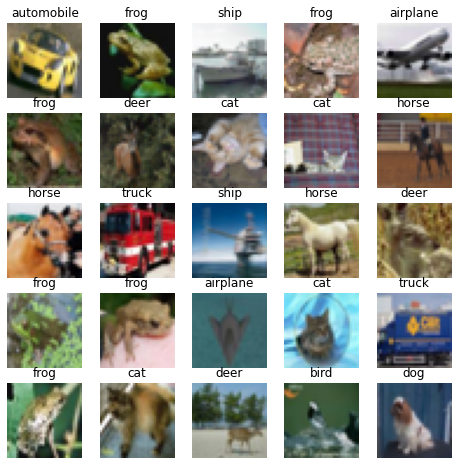

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

## Task 1
Train a decently fit (no underfitting or overfitting) neural network on the CIFAR 10 dataset.
+ Keep track of your validation loss to select the best model
+ You are free to change network hyperparameters and batch size
+ You are free to change optimizer settings and loss function
+ Run your model 5 times with different seeds and report mean and standard deviation of the following metrices on Test Set:
  1. Accuracy for each class
  2. Precision for each class
  3. Recall for each class
  4. F1 score for each class
  5. Visualize the Confusion Matrix (use only mean values for this)



In [ ]:
## Classification Convolution Neural Network

class ConvolutionNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(ConvolutionNeuralNetwork, self).__init__()
    self.conv = torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2),
      torch.nn.BatchNorm2d(64),
      torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2),
      torch.nn.BatchNorm2d(128),
      torch.nn.Dropout(p=0.5),
      torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2),
      torch.nn.BatchNorm2d(256)
    )

    self.fc1 = torch.nn.Linear(256*4*4, 1024)
    self.fc2 = torch.nn.Linear(1024, 264)
    self.fc3 = torch.nn.Linear(264,10)


  def forward(self, data):
    bs = data.shape[0]
    data = self.conv(data)
    data = data.reshape(bs, -1)
    data = torch.relu(self.fc1(data))
    data = torch.relu(self.fc2(data))
    logits = self.fc3(data)
    return logits

In [ ]:
batch_size = 64
max_epoch = 50
train_data = DataLoader(train_dataset, batch_size = batch_size)
test_data = DataLoader(test_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 27.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix
from torchvision import transforms

no_class = len(class_to_idx)

accuracy_fn = MulticlassAccuracy(num_classes=no_class, average=None).cuda()
precision_fn = MulticlassPrecision(num_classes=no_class, average=None).cuda()
recall_fn = MulticlassRecall(num_classes=no_class, average=None).cuda()
f1_fn = MulticlassF1Score(num_classes=no_class, average=None).cuda()

In [ ]:
# Function for training and validatation
def training_routine(model,optimizer,loss_fn,train_data,val_data):
  report_metrics = []
  train_iter_loss = []
  training_loss = []
  valid_iter_loss = []
  validation_loss = []

  print("Epoch\t Training Loss\t \tValidation Loss");
  for epoch in range(max_epoch):
    # Initialization of training and validation loss
    t_loss = 0.0
    v_loss = 0.0

    # Initialize the model in training mode
    model.train()
    # Iterate over Training Data
    for i, batch_data in enumerate(train_data):

      features, labels = batch_data
      features = features.cuda()
      labels = labels.cuda()

      probs = model(features)
      # Initialize the gradients
      optimizer.zero_grad()

      # Apply loss fn
      t_loss_fn = loss_fn(probs, labels)
      # Backpropogation
      t_loss_fn.backward()
      t_loss = t_loss_fn.item()
      train_iter_loss.append(t_loss)
      # Parameter update
      optimizer.step()

    training_loss.append(torch.mean(torch.Tensor(train_iter_loss)))

    # Validation Data
    model.eval()
    with torch.no_grad():
      # Iterate over Validation Data
      for i, valid_data in enumerate(val_data):
        features, labels = valid_data
        features = features.cuda()
        labels = labels.cuda()

        probs = model(features)

        # Apply loss fn
        v_loss_fn = loss_fn(probs, labels)
        v_loss = v_loss_fn.item()
        valid_iter_loss.append(v_loss)

      validation_loss.append(torch.mean(torch.Tensor(valid_iter_loss)))
      print("{0}\t {1}\t {2}".format(epoch, t_loss, v_loss))
  print("\n")

  # Plot a training vs validation loss graph
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(training_loss, label="Training Loss")
  plt.plot(validation_loss, label="Validation Loss")
  plt.legend()
  plt.show()

In [ ]:
# Function for testing
def testing_routine(model,optimizer,loss_fn,test_data):

  report_metrics = []
  res = {}
  total_y_pred = []
  total_y_true = []
  test_confusion_matrix = np.zeros((no_class, no_class), dtype=float)
  global sum_confusion_matrix
  model.eval()
  print("================ Testing Metrics =================")

  # Iterate over testing data
  for data, testing_data in enumerate(test_data):
    inputs, labels = testing_data
    y_inputs, y_true = inputs.cuda(), labels.cuda()

    with torch.no_grad():
      output = model(y_inputs)
      # convert output to predicted class
      y_pred = torch.argmax(output, dim=1)

      total_y_pred += y_pred.cpu().numpy().tolist()
      total_y_true += y_true.cpu().numpy().tolist()

      # Calculating the classification metric
      report_metrics.append({
          "accuracy" : accuracy_fn(y_pred, y_true).cpu().numpy(),
          "precision" : precision_fn(y_pred, y_true).cpu().numpy(),
          "recall" : recall_fn(y_pred, y_true).cpu().numpy(),
          "f1" : f1_fn(y_pred, y_true).cpu().numpy()
      })

  # Calculating multiclass confusion matrix
  test_confusion_matrix = confusion_matrix(total_y_pred, total_y_true)
  sum_confusion_matrix= sum_confusion_matrix + test_confusion_matrix

  # Classwise distribution
  print("Class\t Accuracy\t\t  Precision\t\t  Recall\t\t\t F1")
  for i in range(0, no_class):
    # Calculating mean accuracy for each class
    accuracy = np.round((np.mean([x["accuracy"][i] for x in report_metrics])),4)
    # Calculating mean Precision for each class
    precision = np.round((np.mean([x["precision"][i] for x in report_metrics])),4)
    # Calculating mean Recall for each class
    recall = np.round((np.mean([x["recall"][i] for x in report_metrics])),4)
    # Calculating mean F1 score for each class
    f1 = np.round((np.mean([x["f1"][i] for x in report_metrics])),4)

    print("{0}\t {1}\t {2}\t {3}\t {4}".format( i, accuracy, precision,recall,f1))
    print("\n")
    res[idx_to_class[i]] = {
        "accuracy" : accuracy,
        "precision" : precision,
        "recall" : recall,
        "f1" : f1
    }
  return(res)

In [ ]:
sum_confusion_matrix = np.zeros((no_class, no_class), dtype=float)
# Model for different seeds
def makeModel(task_number):
  count_seed = 5
  accuracies = []
  precisions = []
  recalls = []
  f1s = []
  testing_result = []

  global sum_confusion_matrix
  mean_confusion_mat = np.zeros((no_class, no_class))

  # Loop that run for 5 times with different seeds
  for i in range(count_seed):
    # different seeds generated randomly
    seed = random.randrange(150, 700)
    random.seed(seed)
    torch.manual_seed(seed)

    # Initialize the CNN model
    model = ConvolutionNeuralNetwork().cuda()
    # Initialize the loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    # Initialize the Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0056)

    print("================================================")
    print(f"Seed Count = {i+1}/{count_seed} | Seed = {seed}")

    # Training and Validating the model
    training_routine(model,optimizer,loss_fn,train_data,val_data)
    # Saving the model state
    torch.save(model.state_dict(), f'model_{str(task_number)}_{str(i)}.pt')
    # Testing the model
    testing_result.append(testing_routine(model,optimizer,loss_fn,test_data))

  # Confusion Matrix (mean values)
  mean_confusion_mat = sum_confusion_matrix/count_seed

  for i in range(0, no_class):
    class_i = idx_to_class[i]
    # Accuracy, Precision, Recall, F1 score for each class
    accuracies = [x[class_i]["accuracy"] for x in testing_result]
    precisions = [x[class_i]["precision"] for x in testing_result]
    recalls = [x[class_i]["recall"] for x in testing_result]
    f1s = [x[class_i]["f1"] for x in testing_result]

    # mean of above metrics
    print("Class {0} | Mean | Accuracy:{1} Precision:{2} Recall:{3} F1:{4}".format(i, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))
    # standard deviation of above metrics
    print("Class {0} | Std Deviation | Accuracy:{1} Precision:{2} Recall:{3} F1:{4}".format(i, np.std(accuracies), np.std(precisions), np.std(recalls), np.std(f1s)))
  print("Confusion Matrix \n")
  print(mean_confusion_mat)

Seed Count = 1/5 | Seed = 601
Epoch	 Training Loss	 	Validation Loss
0	 1.1508674621582031	 1.0003600120544434
1	 0.9419338703155518	 0.5842977166175842
2	 0.8122071623802185	 0.6705123782157898
3	 0.7690883874893188	 0.406396746635437
4	 0.7419993281364441	 0.43039774894714355
5	 0.6618887186050415	 0.25159752368927
6	 0.6187981963157654	 0.39248916506767273
7	 0.658379316329956	 0.13879773020744324
8	 0.6326472759246826	 0.20654983818531036
9	 0.756116509437561	 0.081915944814682
10	 0.5462103486061096	 0.1862938106060028
11	 0.6405699849128723	 0.17676028609275818
12	 0.6024193167686462	 0.30585411190986633
13	 0.5907582640647888	 0.11143442988395691
14	 0.557361364364624	 0.17885591089725494
15	 0.584331750869751	 0.15998555719852448
16	 0.4791674017906189	 0.32727158069610596
17	 0.5896941423416138	 0.2548424005508423
18	 0.5020097494125366	 0.178256556391716
19	 0.4845925271511078	 0.2356014996767044
20	 0.5012837052345276	 0.18404649198055267
21	 0.45849400758743286	 0.208326429

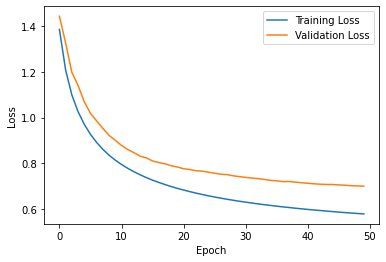

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.890500009059906	 0.7131999731063843	 0.890500009059906	 0.7804999947547913


1	 0.9150000214576721	 0.8794999718666077	 0.9150000214576721	 0.8902000188827515


2	 0.6722000241279602	 0.7107999920845032	 0.6722000241279602	 0.6726999878883362


3	 0.5914999842643738	 0.6929000020027161	 0.5914999842643738	 0.6123999953269958


4	 0.7653999924659729	 0.7465000152587891	 0.7653999924659729	 0.741599977016449


5	 0.5896999835968018	 0.8334000110626221	 0.5896999835968018	 0.6718999743461609


6	 0.8281999826431274	 0.8069999814033508	 0.8281999826431274	 0.8044999837875366


7	 0.8992999792098999	 0.7085999846458435	 0.8992999792098999	 0.7806000113487244


8	 0.8141999840736389	 0.933899998664856	 0.8141999840736389	 0.8600000143051147


9	 0.8414999842643738	 0.8736000061035156	 0.8414999842643738	 0.8482000231742859


Seed Count = 2/5 | Seed = 347
Epoch	 Training Loss	 	Validation Loss

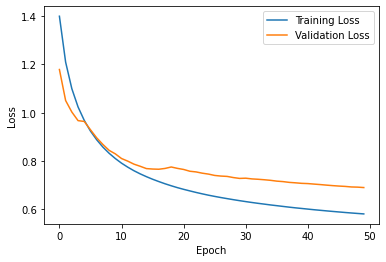

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.817300021648407	 0.7721999883651733	 0.817300021648407	 0.7781000137329102


1	 0.8770999908447266	 0.9337000250816345	 0.8770999908447266	 0.8952999711036682


2	 0.7502999901771545	 0.6330000162124634	 0.7502999901771545	 0.66839998960495


3	 0.6732000112533569	 0.5968000292778015	 0.6732000112533569	 0.6126000285148621


4	 0.8019999861717224	 0.7573000192642212	 0.8019999861717224	 0.7649000287055969


5	 0.5824000239372253	 0.8296999931335449	 0.5824000239372253	 0.6664000153541565


6	 0.7641000151634216	 0.8937000036239624	 0.7641000151634216	 0.8065000176429749


7	 0.8203999996185303	 0.8772000074386597	 0.8203999996185303	 0.8370000123977661


8	 0.9118000268936157	 0.819599986076355	 0.9118000268936157	 0.8532000184059143


9	 0.8604000210762024	 0.8855000138282776	 0.8604000210762024	 0.8646000027656555


Seed Count = 3/5 | Seed = 508
Epoch	 Training Loss	 	Validation Loss


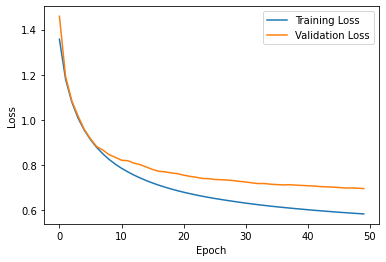

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.7512000203132629	 0.8309000134468079	 0.7512000203132629	 0.7734000086784363


1	 0.9265000224113464	 0.8410000205039978	 0.9265000224113464	 0.8715999722480774


2	 0.7084000110626221	 0.6894999742507935	 0.7084000110626221	 0.6812999844551086


3	 0.6858999729156494	 0.6402000188827515	 0.6858999729156494	 0.640999972820282


4	 0.8050000071525574	 0.7261000275611877	 0.8050000071525574	 0.7487999796867371


5	 0.6527000069618225	 0.7418000102043152	 0.6527000069618225	 0.6765999794006348


6	 0.796500027179718	 0.8432999849319458	 0.796500027179718	 0.8047999739646912


7	 0.7509999871253967	 0.9035999774932861	 0.7509999871253967	 0.8086000084877014


8	 0.8622000217437744	 0.8823999762535095	 0.8622000217437744	 0.8621000051498413


9	 0.9014999866485596	 0.7888000011444092	 0.9014999866485596	 0.8314999938011169


Seed Count = 4/5 | Seed = 579
Epoch	 Training Loss	 	Validation Los

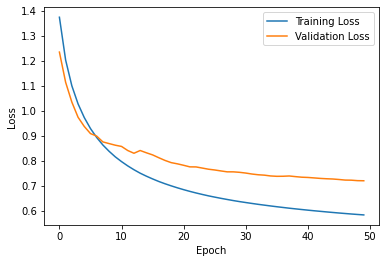

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.808899998664856	 0.7635999917984009	 0.808899998664856	 0.7734000086784363


1	 0.8356000185012817	 0.9294000267982483	 0.8356000185012817	 0.8682000041007996


2	 0.6969000101089478	 0.679099977016449	 0.6969000101089478	 0.6686999797821045


3	 0.4973999857902527	 0.6980000138282776	 0.4973999857902527	 0.5597000122070312


4	 0.7910000085830688	 0.633400022983551	 0.7910000085830688	 0.6869999766349792


5	 0.7322999835014343	 0.6859999895095825	 0.7322999835014343	 0.6919000148773193


6	 0.6011999845504761	 0.906499981880188	 0.6011999845504761	 0.7046999931335449


7	 0.925000011920929	 0.6679999828338623	 0.925000011920929	 0.7652999758720398


8	 0.786899983882904	 0.9240999817848206	 0.786899983882904	 0.8349999785423279


9	 0.8690000176429749	 0.8133999705314636	 0.8690000176429749	 0.8306000232696533


Seed Count = 5/5 | Seed = 473
Epoch	 Training Loss	 	Validation Loss
0	 1

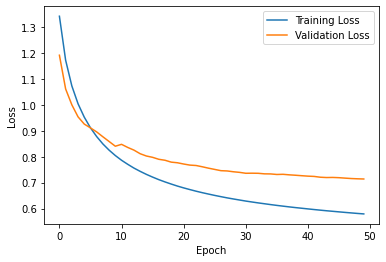

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8511000275611877	 0.7253999710083008	 0.8511000275611877	 0.7728999853134155


1	 0.8356999754905701	 0.9746000170707703	 0.8356999754905701	 0.891700029373169


2	 0.7085000276565552	 0.6765000224113464	 0.7085000276565552	 0.6733999848365784


3	 0.7644000053405762	 0.5167999863624573	 0.7644000053405762	 0.6008999943733215


4	 0.732699990272522	 0.767799973487854	 0.732699990272522	 0.7355999946594238


5	 0.6791999936103821	 0.7468000054359436	 0.6791999936103821	 0.6951000094413757


6	 0.7329999804496765	 0.8472999930381775	 0.7329999804496765	 0.7705000042915344


7	 0.7752000093460083	 0.8973000049591064	 0.7752000093460083	 0.819100022315979


8	 0.8202999830245972	 0.896399974822998	 0.8202999830245972	 0.8465999960899353


9	 0.803600013256073	 0.8920000195503235	 0.803600013256073	 0.8343999981880188


Class 0 | Mean | Accuracy:0.8237999677658081 Precision:0.761059939861297

In [ ]:
#Task1  decently fit neural network on the CIFAR 10 dataset
task1= makeModel(1)

## Task 2: Data Augmentation

Perform the following data augmentation techniques to increase the number of samples in your train set:

1. Rotate Image at an arbitrary angle
2. Crop Image from the center and resize
3. Flip Image from left to right (Create a mirror image)

Train your network on the augmented dataset 5 times with different seeds and campare results with previously trained network on Test Set.

Task 2
Seed Count = 1/5 | Seed = 494
Epoch	 Training Loss	 	Validation Loss
0	 0.9415874481201172	 0.6658596992492676
1	 0.9168466329574585	 0.557915210723877
2	 0.8419409990310669	 0.3015097677707672
3	 0.8812279105186462	 0.2819501757621765
4	 0.6354241371154785	 0.29550057649612427
5	 0.6906901001930237	 0.5618283152580261
6	 0.5235106945037842	 0.3676646649837494
7	 0.5730908513069153	 0.19234170019626617
8	 0.587780773639679	 0.29166433215141296
9	 0.5462883710861206	 0.42198193073272705
10	 0.5897572040557861	 0.4699561595916748
11	 0.5992071032524109	 0.2225750982761383
12	 0.6003578901290894	 0.18503090739250183
13	 0.6077122092247009	 0.18216128647327423
14	 0.619562029838562	 0.17086032032966614
15	 0.6072447299957275	 0.17501941323280334
16	 0.574569582939148	 0.2125784158706665
17	 0.6289481520652771	 0.16381904482841492
18	 0.5488753318786621	 0.14585009217262268
19	 0.5637261271476746	 0.07490429282188416
20	 0.4944075047969818	 0.16492174565792084
21	 0.3777533173561096	

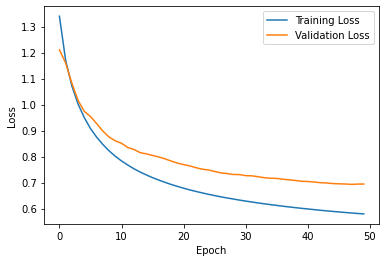

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8865000009536743	 0.6376000046730042	 0.8865000009536743	 0.728600025177002


1	 0.9063000082969666	 0.8718000054359436	 0.9063000082969666	 0.8790000081062317


2	 0.6195999979972839	 0.7170000076293945	 0.6195999979972839	 0.644599974155426


3	 0.5523999929428101	 0.6922000050544739	 0.5523999929428101	 0.5909000039100647


4	 0.8716999888420105	 0.5924999713897705	 0.8716999888420105	 0.6915000081062317


5	 0.579200029373169	 0.8147000074386597	 0.579200029373169	 0.6608999967575073


6	 0.5573999881744385	 0.9190999865531921	 0.5573999881744385	 0.6729999780654907


7	 0.8205000162124634	 0.7955999970436096	 0.8205000162124634	 0.7928000092506409


8	 0.8450999855995178	 0.8287000060081482	 0.8450999855995178	 0.8230999708175659


9	 0.8597000241279602	 0.8123999834060669	 0.8597000241279602	 0.8270999789237976


Seed Count = 2/5 | Seed = 303
Epoch	 Training Loss	 	Validation Loss

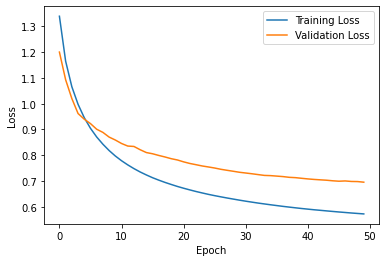

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8410000205039978	 0.7717000246047974	 0.8410000205039978	 0.7911999821662903


1	 0.8980000019073486	 0.9081000089645386	 0.8980000019073486	 0.8952000141143799


2	 0.6881999969482422	 0.7178999781608582	 0.6881999969482422	 0.6852999925613403


3	 0.5512999892234802	 0.7440000176429749	 0.5512999892234802	 0.6108999848365784


4	 0.8504999876022339	 0.6992999911308289	 0.8504999876022339	 0.7529000043869019


5	 0.7233999967575073	 0.7265999913215637	 0.7233999967575073	 0.7099999785423279


6	 0.845300018787384	 0.8323000073432922	 0.845300018787384	 0.8259999752044678


7	 0.8309000134468079	 0.8572999835014343	 0.8309000134468079	 0.8312000036239624


8	 0.8711000084877014	 0.8729000091552734	 0.8711000084877014	 0.8608999848365784


9	 0.873199999332428	 0.8788999915122986	 0.873199999332428	 0.8669000267982483


Seed Count = 3/5 | Seed = 182
Epoch	 Training Loss	 	Validation Loss

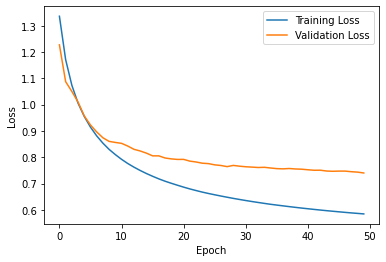

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8248000144958496	 0.7770000100135803	 0.8248000144958496	 0.7851999998092651


1	 0.9157000184059143	 0.8794000148773193	 0.9157000184059143	 0.8866000175476074


2	 0.6736000180244446	 0.7457000017166138	 0.6736000180244446	 0.6884999871253967


3	 0.6552000045776367	 0.6647999882698059	 0.6552000045776367	 0.6370000243186951


4	 0.8215000033378601	 0.728600025177002	 0.8215000033378601	 0.7562000155448914


5	 0.6561999917030334	 0.7955999970436096	 0.6561999917030334	 0.7026000022888184


6	 0.8295999765396118	 0.8364999890327454	 0.8295999765396118	 0.8197000026702881


7	 0.8513000011444092	 0.8436999917030334	 0.8513000011444092	 0.8352000117301941


8	 0.8593999743461609	 0.8924999833106995	 0.8593999743461609	 0.8644000291824341


9	 0.871399998664856	 0.8539999723434448	 0.871399998664856	 0.8528000116348267


Seed Count = 4/5 | Seed = 612
Epoch	 Training Loss	 	Validation Los

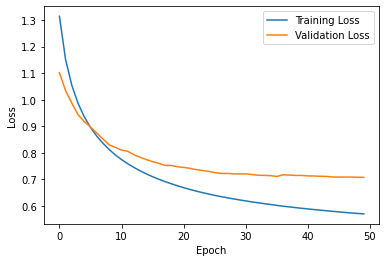

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.7569000124931335	 0.8112000226974487	 0.7569000124931335	 0.7660999894142151


1	 0.8414000272750854	 0.91839998960495	 0.8414000272750854	 0.8675000071525574


2	 0.5893999934196472	 0.7635999917984009	 0.5893999934196472	 0.6471999883651733


3	 0.5968000292778015	 0.7019000053405762	 0.5968000292778015	 0.6241999864578247


4	 0.8842999935150146	 0.5356000065803528	 0.8842999935150146	 0.6541000008583069


5	 0.6690999865531921	 0.7727000117301941	 0.6690999865531921	 0.7024000287055969


6	 0.6976000070571899	 0.8794999718666077	 0.6976000070571899	 0.761900007724762


7	 0.8723999857902527	 0.7694000005722046	 0.8723999857902527	 0.8050000071525574


8	 0.8623999953269958	 0.8658000230789185	 0.8623999953269958	 0.854200005531311


9	 0.8841999769210815	 0.8230999708175659	 0.8841999769210815	 0.8402000069618225


Seed Count = 5/5 | Seed = 380
Epoch	 Training Loss	 	Validation Loss

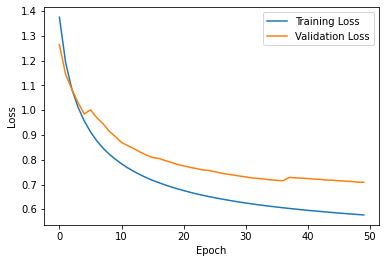

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8561000227928162	 0.7098000049591064	 0.8561000227928162	 0.7623999714851379


1	 0.8154000043869019	 0.9617999792098999	 0.8154000043869019	 0.8716999888420105


2	 0.661899983882904	 0.6449000239372253	 0.661899983882904	 0.633400022983551


3	 0.6029000282287598	 0.6625999808311462	 0.6029000282287598	 0.6071000099182129


4	 0.9156000018119812	 0.541100025177002	 0.9156000018119812	 0.6662999987602234


5	 0.5460000038146973	 0.8325999975204468	 0.5460000038146973	 0.6409000158309937


6	 0.6589999794960022	 0.8593000173568726	 0.6589999794960022	 0.7289000153541565


7	 0.7781999707221985	 0.8733000159263611	 0.7781999707221985	 0.8130999803543091


8	 0.8306999802589417	 0.9333999752998352	 0.8306999802589417	 0.8662999868392944


9	 0.8855000138282776	 0.8097000122070312	 0.8855000138282776	 0.8366000056266785


Class 0 | Mean | Accuracy:0.8330599665641785 Precision:0.74145996570

In [ ]:
# Task 2
import torchvision.transforms

# data augmentation
transform_params = transforms.Compose([transforms.RandomRotation(degrees=55),
                                       transforms.CenterCrop(10),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0, 0, 0], [1, 1, 1])])
# Transforming the dataset based upon the data augmentation parameters
train_dataset.transform = transform_params
# Loading the data
train_data = DataLoader(train_dataset, batch_size = batch_size)

print("Task 2")
task_number = 2
# Training the model for the augumented data
task2 = makeModel(task_number)

In [ ]:
from google.colab import files
files.download('/content/model_1_0.pt')
files.download('/content/model_1_1.pt')
files.download('/content/model_1_2.pt')
files.download('/content/model_1_3.pt')
files.download('/content/model_1_4.pt')
files.download('/content/model_2_0.pt')
files.download('/content/model_2_1.pt')
files.download('/content/model_2_2.pt')
files.download('/content/model_2_3.pt')
files.download('/content/model_2_4.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Task 3: Adversarial Samples

1. Create a Adversarial Test Set by adding a noise sampled from $\sim\mathcal{N}(\mu = 0, \sigma = 0.01)$ to the given Test Set.
2. Compare models obtained in Task 1 and Task 2 on Adversarial Test Set
3. Augment train set by adding noise to samples from train set. (You should have both normal samples and noise added samples in train set)
4. Train your model 5 times with different seeds on noise augmented train set and report results on normal Test Set and Adversarial Test Set

In [ ]:
from torch.utils.data import ConcatDataset

# Augment test set by adding noise
adversarial_test_data = []
for x, y in test_dataset:
    # adding a noise sampled from mean =0 and std dev =0.01
    x_noisy = x + torch.randn_like(x) * 0.01
    adversarial_test_data.append((x_noisy, y))

adversarial_test_data = [(x_tensor, y_tensor) for x_tensor, y_tensor in adversarial_test_data]
x_tensor, y_tensor = zip(*adversarial_test_data)
x_tensor = torch.stack(x_tensor)
y_tensor = torch.LongTensor(y_tensor)

adversarial_test_data = torch.utils.data.TensorDataset(x_tensor, y_tensor)
adversarial_test_data_loader = DataLoader(adversarial_test_data, batch_size=batch_size)

# Augment train set by adding noise
adversarial_train_data = []
for x, y in train_dataset:
    # adding a noise sampled from mean =0 and std dev =0.01
    x_noisy = x + torch.randn_like(x) * 0.01

    adversarial_train_data.append((x_noisy, y))

adversarial_train_data = [(x_tensor, y_tensor) for x_tensor, y_tensor in adversarial_train_data]
x_tensor, y_tensor = zip(*adversarial_train_data)
x_tensor = torch.stack(x_tensor)
y_tensor = torch.LongTensor(y_tensor)

# Augment train set by adding noise to samples from train set (both normal samples and noise added samples in train set)
adversarial_train_data = torch.utils.data.TensorDataset(x_tensor, y_tensor)
combined_dataset = ConcatDataset([train_data, adversarial_train_data])
adversarial_train_data_loader = DataLoader(combined_dataset, batch_size=batch_size)


In [ ]:
model = ConvolutionNeuralNetwork().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0056)

model_path = "model_{}_{}.pt"
data_path = "data"

# Comparing models obtained in Task 1 and Task 2 on Adversarial Test Set
for i in range(1,3):
  for j in range(5):
    model_name = model_path.format(i, j)
    print(model_name)
    # Load the model from previous task
    model.load_state_dict(torch.load(model_name))
    # Testing it on Adversarial Test Set
    print("========Adversarial Test Set=========")
    testing_routine(model,optimizer,loss_fn,adversarial_test_data_loader)

model_1_0.pt
========Adversarial Test Set=========
================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8747000098228455	 0.7401000261306763	 0.8747000098228455	 0.7893000245094299


1	 0.9071999788284302	 0.8959000110626221	 0.9071999788284302	 0.8942000269889832


2	 0.6603000164031982	 0.715399980545044	 0.6603000164031982	 0.6669999957084656


3	 0.5830000042915344	 0.7052000164985657	 0.5830000042915344	 0.6122999787330627


4	 0.777899980545044	 0.7138000130653381	 0.777899980545044	 0.7311999797821045


5	 0.5782999992370605	 0.8357999920845032	 0.5782999992370605	 0.6629999876022339


6	 0.8464000225067139	 0.7820000052452087	 0.8464000225067139	 0.79830002784729


7	 0.8888999819755554	 0.7113000154495239	 0.8888999819755554	 0.7788000106811523


8	 0.8490999937057495	 0.9194999933242798	 0.8490999937057495	 0.8736000061035156


9	 0.8378000259399414	 0.8730999827384949	 0.8378000259399414	 0.8445000052452087


model_1_1.pt
=====

In [ ]:
sum_confusion_matrix = np.zeros((no_class, no_class), dtype=float)
# Model for different seeds
def makeModel_task3(task_number,data_to_test):
  count_seed = 5
  accuracies = []
  precisions = []
  recalls = []
  f1s = []
  testing_result = []

  global sum_confusion_matrix
  global batch_size, adversarial_test_data_loader, val_data, loss_fn, model, optimizer, max_epochs, adversarial_train_data_loader
  mean_confusion_mat = np.zeros((no_class, no_class))

  test_data = DataLoader(test_dataset, batch_size = batch_size)
  val_data = DataLoader(val_dataset, batch_size = batch_size)

  adversarial_train_data_loader = DataLoader(adversarial_train_data, batch_size=batch_size)
  adversarial_test_data_loader = DataLoader(adversarial_test_data, batch_size=batch_size)

  # Loop that run for 5 times with different seeds
  for i in range(count_seed):
    # different seeds generated randomly
    seed = random.randrange(150, 700)
    random.seed(seed)
    torch.manual_seed(seed)

    # Initialize the CNN model
    model = ConvolutionNeuralNetwork().cuda()
    # Initialize the loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    # Initialize the Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0056)

    print("================================================")
    print(f"Seed Count = {i+1}/{count_seed} | Seed = {seed}")

    # Training and Validating the model
    training_routine(model,optimizer,loss_fn,adversarial_train_data_loader,val_data)
    # Saving the model state
    torch.save(model.state_dict(), f'model_{str(task_number)}_{str(i)}.pt')
    # Testing the model
    testing_result.append(testing_routine(model,optimizer,loss_fn,data_to_test))

  # Confusion Matrix (mean values)
  mean_confusion_mat = sum_confusion_matrix/count_seed

  for i in range(0, no_class):
    class_i = idx_to_class[i]
    # Accuracy, Precision, Recall, F1 score for each class
    accuracies = [x[class_i]["accuracy"] for x in testing_result]
    precisions = [x[class_i]["precision"] for x in testing_result]
    recalls = [x[class_i]["recall"] for x in testing_result]
    f1s = [x[class_i]["f1"] for x in testing_result]

    # mean of above metrics
    print("Class {0} | Mean | Accuracy:{1} Precision:{2} Recall:{3} F1:{4}".format(i, np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))
    # standard deviation of above metrics
    print("Class {0} | Std Deviation | Accuracy:{1} Precision:{2} Recall:{3} F1:{4}".format(i, np.std(accuracies), np.std(precisions), np.std(recalls), np.std(f1s)))
  print("Confusion Matrix \n")
  print(mean_confusion_mat)

Train the model 5 times with different seeds on noise augmented train set testing on normal Test Set
Seed Count = 1/5 | Seed = 303
Epoch	 Training Loss	 	Validation Loss
0	 1.0208832025527954	 0.6040726900100708
1	 0.9276348948478699	 0.6067909598350525
2	 0.8295198678970337	 0.4028105139732361
3	 0.9253648519515991	 0.38642603158950806
4	 0.7047287225723267	 0.4275011420249939
5	 0.6219081878662109	 0.368744820356369
6	 0.6492703557014465	 0.3050394654273987
7	 0.5944554209709167	 0.48355549573898315
8	 0.6791465878486633	 0.2825133204460144
9	 0.6410328149795532	 0.29960036277770996
10	 0.5444416403770447	 0.22697030007839203
11	 0.6446512341499329	 0.4886094331741333
12	 0.5395664572715759	 0.3745260238647461
13	 0.5845664739608765	 0.21494069695472717
14	 0.5572137832641602	 0.44741445779800415
15	 0.4920002222061157	 0.3823423981666565
16	 0.4743255078792572	 0.3692408800125122
17	 0.5059406757354736	 0.5361101031303406
18	 0.5128863453865051	 0.3014417588710785
19	 0.636011302471

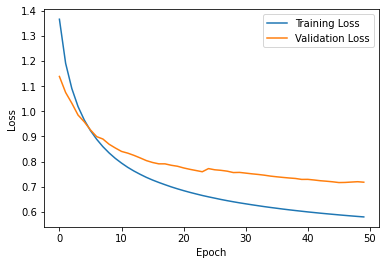

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8593000173568726	 0.7160000205039978	 0.8593000173568726	 0.7703999876976013


1	 0.873199999332428	 0.9251999855041504	 0.873199999332428	 0.8894000053405762


2	 0.6741999983787537	 0.6791999936103821	 0.6741999983787537	 0.657800018787384


3	 0.6312999725341797	 0.6442000269889832	 0.6312999725341797	 0.6183000206947327


4	 0.7408000230789185	 0.7120000123977661	 0.7408000230789185	 0.7113000154495239


5	 0.724399983882904	 0.6646999716758728	 0.724399983882904	 0.6812999844551086


6	 0.6662999987602234	 0.8978999853134155	 0.6662999987602234	 0.7490000128746033


7	 0.826200008392334	 0.8428000211715698	 0.826200008392334	 0.8216999769210815


8	 0.8677999973297119	 0.8561000227928162	 0.8677999973297119	 0.8528000116348267


9	 0.8683000206947327	 0.8672999739646912	 0.8683000206947327	 0.8572999835014343


Seed Count = 2/5 | Seed = 182
Epoch	 Training Loss	 	Validation Loss
0	

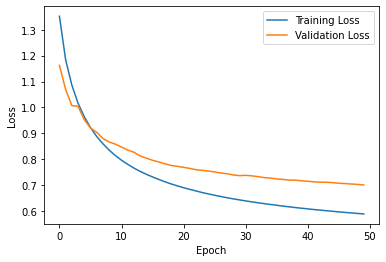

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8015000224113464	 0.7847999930381775	 0.8015000224113464	 0.7796000242233276


1	 0.8894000053405762	 0.9064000248908997	 0.8894000053405762	 0.8906000256538391


2	 0.7168999910354614	 0.7293999791145325	 0.7168999910354614	 0.7067999839782715


3	 0.6696000099182129	 0.6399999856948853	 0.6696000099182129	 0.635699987411499


4	 0.717199981212616	 0.7944999933242798	 0.717199981212616	 0.7372999787330627


5	 0.652999997138977	 0.7580000162124634	 0.652999997138977	 0.6877999901771545


6	 0.8411999940872192	 0.8313999772071838	 0.8411999940872192	 0.8227999806404114


7	 0.8992999792098999	 0.7610999941825867	 0.8992999792098999	 0.8130000233650208


8	 0.8378000259399414	 0.9239000082015991	 0.8378000259399414	 0.8697999715805054


9	 0.8952000141143799	 0.824999988079071	 0.8952000141143799	 0.8496999740600586


Seed Count = 3/5 | Seed = 612
Epoch	 Training Loss	 	Validation Loss
0

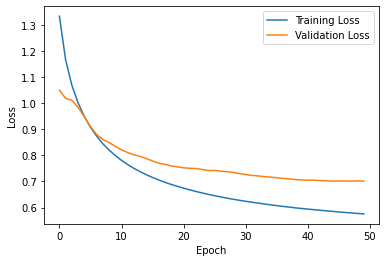

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8012999892234802	 0.7480000257492065	 0.8012999892234802	 0.7605999708175659


1	 0.9333000183105469	 0.8539000153541565	 0.9333000183105469	 0.8833000063896179


2	 0.7709000110626221	 0.5874000191688538	 0.7709000110626221	 0.6510000228881836


3	 0.642300009727478	 0.6259999871253967	 0.642300009727478	 0.6122999787330627


4	 0.8158000111579895	 0.6740000247955322	 0.8158000111579895	 0.7239999771118164


5	 0.6448000073432922	 0.786899983882904	 0.6448000073432922	 0.6909999847412109


6	 0.6743000149726868	 0.9028000235557556	 0.6743000149726868	 0.7573000192642212


7	 0.8129000067710876	 0.8410999774932861	 0.8129000067710876	 0.8169000148773193


8	 0.7630000114440918	 0.9513000249862671	 0.7630000114440918	 0.8324000239372253


9	 0.8281000256538391	 0.8910999894142151	 0.8281000256538391	 0.8475000262260437


Seed Count = 4/5 | Seed = 380
Epoch	 Training Loss	 	Validation Los

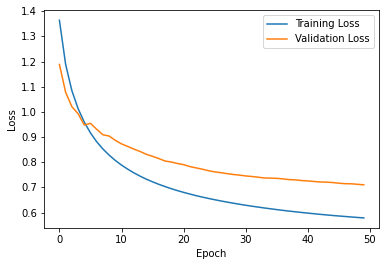

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8004999756813049	 0.7791000008583069	 0.8004999756813049	 0.7742000222206116


1	 0.9218999743461609	 0.8634999990463257	 0.9218999743461609	 0.8827000260353088


2	 0.7864999771118164	 0.5928000211715698	 0.7864999771118164	 0.660099983215332


3	 0.6304000020027161	 0.6705999970436096	 0.6304000020027161	 0.6309999823570251


4	 0.7914000153541565	 0.7577000260353088	 0.7914000153541565	 0.7601000070571899


5	 0.6963000297546387	 0.7390000224113464	 0.6963000297546387	 0.7024000287055969


6	 0.779699981212616	 0.9013000130653381	 0.779699981212616	 0.8237000107765198


7	 0.7763000130653381	 0.9118000268936157	 0.7763000130653381	 0.8266000151634216


8	 0.794700026512146	 0.9286999702453613	 0.794700026512146	 0.8450999855995178


9	 0.8820000290870667	 0.8657000064849854	 0.8820000290870667	 0.8633000254631042


Seed Count = 5/5 | Seed = 285
Epoch	 Training Loss	 	Validation Loss


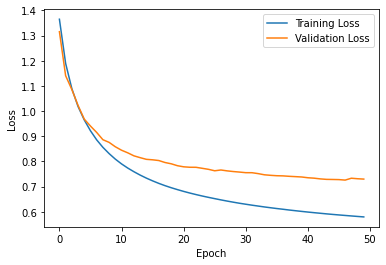

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.9301000237464905	 0.5914999842643738	 0.9301000237464905	 0.7113000154495239


1	 0.9437000155448914	 0.8461999893188477	 0.9437000155448914	 0.8841999769210815


2	 0.699400007724762	 0.6603000164031982	 0.699400007724762	 0.6622999906539917


3	 0.590499997138977	 0.6538000106811523	 0.590499997138977	 0.599399983882904


4	 0.7095000147819519	 0.7915999889373779	 0.7095000147819519	 0.7310000061988831


5	 0.6700000166893005	 0.7390000224113464	 0.6700000166893005	 0.684499979019165


6	 0.7433000206947327	 0.9000999927520752	 0.7433000206947327	 0.8003000020980835


7	 0.8464000225067139	 0.8061000108718872	 0.8464000225067139	 0.8144999742507935


8	 0.7588000297546387	 0.9286999702453613	 0.7588000297546387	 0.8217999935150146


9	 0.7893999814987183	 0.9235000014305115	 0.7893999814987183	 0.8414000272750854


Class 0 | Mean | Accuracy:0.8385399580001831 Precision:0.7238799929618

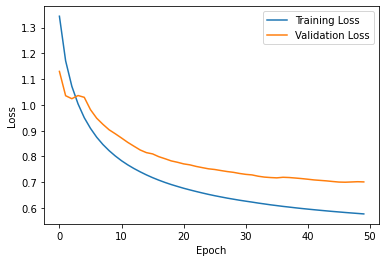

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.7896999716758728	 0.7572000026702881	 0.7896999716758728	 0.7548999786376953


1	 0.8855000138282776	 0.9097999930381775	 0.8855000138282776	 0.8888999819755554


2	 0.6431999802589417	 0.6881999969482422	 0.6431999802589417	 0.6456999778747559


3	 0.7024999856948853	 0.5569000244140625	 0.7024999856948853	 0.6025999784469604


4	 0.8258000016212463	 0.6362000107765198	 0.8258000016212463	 0.704200029373169


5	 0.5620999932289124	 0.8195000290870667	 0.5620999932289124	 0.6467000246047974


6	 0.8216999769210815	 0.8270999789237976	 0.8216999769210815	 0.810699999332428


7	 0.8379999995231628	 0.8059999942779541	 0.8379999995231628	 0.809499979019165


8	 0.7957000136375427	 0.9442999958992004	 0.7957000136375427	 0.8521999716758728


9	 0.8145999908447266	 0.9079999923706055	 0.8145999908447266	 0.8468000292778015


Seed Count = 2/5 | Seed = 363
Epoch	 Training Loss	 	Validation Los

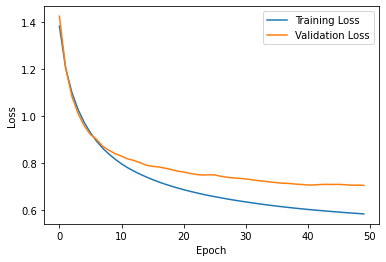

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.7924000024795532	 0.7530999779701233	 0.7924000024795532	 0.7573999762535095


1	 0.9151999950408936	 0.853600025177002	 0.9151999950408936	 0.8736000061035156


2	 0.7376999855041504	 0.6241999864578247	 0.7376999855041504	 0.6608999967575073


3	 0.6901999711990356	 0.6230999827384949	 0.6901999711990356	 0.6363000273704529


4	 0.8179000020027161	 0.7172999978065491	 0.8179000020027161	 0.7473000288009644


5	 0.5989999771118164	 0.8323000073432922	 0.5989999771118164	 0.6761000156402588


6	 0.7979000210762024	 0.8855000138282776	 0.7979000210762024	 0.8227999806404114


7	 0.7910000085830688	 0.8892999887466431	 0.7910000085830688	 0.8248000144958496


8	 0.7353000044822693	 0.9460999965667725	 0.7353000044822693	 0.8158000111579895


9	 0.9024999737739563	 0.8072999715805054	 0.9024999737739563	 0.8424999713897705


Seed Count = 3/5 | Seed = 324
Epoch	 Training Loss	 	Validation L

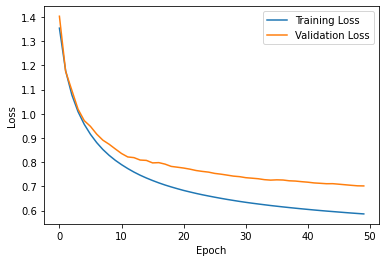

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8973000049591064	 0.6283000111579895	 0.8973000049591064	 0.7271000146865845


1	 0.90829998254776	 0.89410001039505	 0.90829998254776	 0.8942000269889832


2	 0.6807000041007996	 0.680899977684021	 0.6807000041007996	 0.6622999906539917


3	 0.6417999863624573	 0.6468999981880188	 0.6417999863624573	 0.6266999840736389


4	 0.8108999729156494	 0.6563000082969666	 0.8108999729156494	 0.710099995136261


5	 0.5884000062942505	 0.8187000155448914	 0.5884000062942505	 0.6672999858856201


6	 0.5756000280380249	 0.9110000133514404	 0.5756000280380249	 0.6845999956130981


7	 0.835099995136261	 0.8500999808311462	 0.835099995136261	 0.8305000066757202


8	 0.8511000275611877	 0.8210999965667725	 0.8511000275611877	 0.8263000249862671


9	 0.8508999943733215	 0.8863000273704529	 0.8508999943733215	 0.8569999933242798


Seed Count = 4/5 | Seed = 322
Epoch	 Training Loss	 	Validation Loss
0	 1.

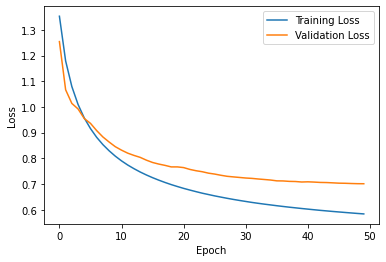

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8215000033378601	 0.7473000288009644	 0.8215000033378601	 0.7698000073432922


1	 0.8776999711990356	 0.9115999937057495	 0.8776999711990356	 0.8840000033378601


2	 0.6078000068664551	 0.6725999712944031	 0.6078000068664551	 0.6223999857902527


3	 0.5113999843597412	 0.7294999957084656	 0.5113999843597412	 0.5760999917984009


4	 0.8881000280380249	 0.538100004196167	 0.8881000280380249	 0.6568999886512756


5	 0.5834000110626221	 0.7871000170707703	 0.5834000110626221	 0.6516000032424927


6	 0.6502000093460083	 0.885200023651123	 0.6502000093460083	 0.7330999970436096


7	 0.8486999869346619	 0.7914000153541565	 0.8486999869346619	 0.8080000281333923


8	 0.9078999757766724	 0.7921000123023987	 0.9078999757766724	 0.8360000252723694


9	 0.852400004863739	 0.8468000292778015	 0.852400004863739	 0.8409000039100647


Seed Count = 5/5 | Seed = 579
Epoch	 Training Loss	 	Validation Loss

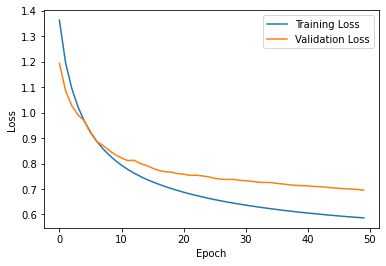

================ Testing Metrics =================
Class	 Accuracy		  Precision		  Recall			 F1
0	 0.8066999912261963	 0.7883999943733215	 0.8066999912261963	 0.7843999862670898


1	 0.9002000093460083	 0.9447000026702881	 0.9002000093460083	 0.9140999913215637


2	 0.6733999848365784	 0.7700999975204468	 0.6733999848365784	 0.6992999911308289


3	 0.6972000002861023	 0.6434999704360962	 0.6972000002861023	 0.6528000235557556


4	 0.8235999941825867	 0.7120000123977661	 0.8235999941825867	 0.7480000257492065


5	 0.614300012588501	 0.8080000281333923	 0.614300012588501	 0.6791999936103821


6	 0.840399980545044	 0.8406999707221985	 0.840399980545044	 0.8296999931335449


7	 0.8339999914169312	 0.8651999831199646	 0.8339999914169312	 0.8377000093460083


8	 0.9014999866485596	 0.8540999889373779	 0.9014999866485596	 0.8689000010490417


9	 0.8982999920845032	 0.8302000164985657	 0.8982999920845032	 0.8536999821662903


Class 0 | Mean | Accuracy:0.8215200304985046 Precision:0.73486000299

In [ ]:
from torch.utils.data.dataloader import DataLoader

# Train the model 5 times with different seeds on noise augmented train set testing on normal Test Set
print("Train the model 5 times with different seeds on noise augmented train set testing on normal Test Set")
task3_1 = makeModel_task3(3,test_data)

# Train the model 5 times with different seeds on noise augmented train set testing on Adversarial Test Set
print("Train the model 5 times with different seeds on noise augmented train set testing on Adversarial Test Set")
task3_2 = makeModel_task3(4,adversarial_test_data_loader)

In [ ]:
from google.colab import files
files.download('/content/model_4_0.pt')
files.download('/content/model_4_1.pt')
files.download('/content/model_4_2.pt')
files.download('/content/model_4_3.pt')
files.download('/content/model_4_4.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Augmentation leads to a significant increase in training time, likely due to augmentation making it harder for the model to learn. Augmentation strategy with an increase in accuracy in prediction around ~1-2% per class.
Adversarial transformation is the augmentation tested leading to changes in accuracy. Though in the presence of adversarial test data, the model can misinterpret the input. By employing the adversial training , the issue is resolved. Making the the model more robust.
